In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import os
from torch import nn
import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer

import tokenizers
from tokenizers import ByteLevelBPETokenizer, BertWordPieceTokenizer

torch.__version__

'1.9.1'

In [2]:
%%capture nop
!pip install positional-encodings
from positional_encodings import (PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D,
                                  Summer)

In [3]:
!rm -rf PoS-Tagging
!git clone https://github.com/Janluke0/PoS-Tagging/
os.chdir('PoS-Tagging')

Cloning into 'PoS-Tagging'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 120 (delta 50), reused 99 (delta 29), pack-reused 0
Receiving objects: 100% (120/120), 15.66 MiB | 33.76 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [4]:
from model.transformers import transformer as tr
from dataset import TWITADS

In [5]:
_TAGS = {'ADJ': 0, 'ADP': 1, 'ADP_A': 2, 'ADV': 3,
            'AUX': 4, 'CONJ': 5, 'DET': 6, 'EMO': 7,
            'HASHTAG': 8, 'INTJ': 9, 'MENTION': 10,
            'NOUN': 11, 'NUM': 12, 'PART': 13, 'PRON': 14,
            'PROPN': 15, 'PUNCT': 16, 'SCONJ': 17, 'SYM': 18,
            'URL': 19, 'VERB': 20, 'VERB_CLIT': 21, 'X': 22,
            '[BOS]':23,'[EOS]':24, 
            '[UNS0]':25, '[UNS1]':26, '[UNS2]':27,
            '[PAD]':-100}

In [6]:
# initialize
my_tokenizer =  ByteLevelBPETokenizer()
word_tokenizer = lambda w: [w] 
ds = TWITADS('resampled_train', word_tokenizer)
sentences = [' '.join(w) for w,_ in ds]
# and train
my_tokenizer.train_from_iterator(sentences, vocab_size=2048, min_frequency=1,
                special_tokens=['[PAD]', '[BOS]', '[EOS]', '[MASK]', '[UNK]'])
my_tokenizer.post_processor = tokenizers.processors.TemplateProcessing(single='<s> $A </s>',
                                                             special_tokens=[('<s>', my_tokenizer.token_to_id('[BOS]')), 
                                                                             ('</s>', my_tokenizer.token_to_id('[EOS]'))])

In [7]:
%%capture test_tknzr
x = " ".join(ds[0][0])
enc = my_tokenizer.encode(x, is_pretokenized=False)
list(zip(enc.offsets,enc.ids)), my_tokenizer.decode(enc.ids), enc.tokens
out =""
for b,e in enc.offsets:
    out += x[b:e]
out.split(" "), list(zip(enc.word_ids,enc.tokens, enc.ids))

In [8]:

def tokenize_and_align_labels(tokenizer, tokens, tags):
    tokens = [" "+w if i>0 else w for i,w in enumerate(list(tokens))]
    tokenized_inputs = tokenizer.encode(tokens, is_pretokenized=True)
    
    word_ids = tokenized_inputs.word_ids # Map tokens to their respective word.
    previous_word_idx = None
    label_ids = [23]
    for word_idx in word_ids:     
        if word_idx is None:
            pass#label_ids.append(-100)
        else:
            label_ids.append(tags[word_idx])                
    label_ids.append(24)
    
    return torch.tensor(tokenized_inputs.ids), torch.tensor(label_ids)

def collate_fn(batch):
    tokens, tags = zip(*batch)
    return pad_sequence(tokens, batch_first=True), pad_sequence(tags, padding_value=-100, batch_first=True)


#tknzr = AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-cased")

tknzr = my_tokenizer
def mk_dl(ds_names=['train', 'test'], batch_size=64, shuffle=True):
    def transformer(tkns, tags): 
        return tokenize_and_align_labels(tknzr,tkns,tags)
    word_tokenizer = lambda w: [w] 
    
    dataloaders = []
    
    for name in ds_names:
        ds = TWITADS(name, word_tokenizer,
                       transform=transformer)
        dataloaders.append(DataLoader(ds, shuffle=shuffle,
                   batch_size=batch_size, collate_fn=collate_fn))
    return (ds.n_tags,*dataloaders)
    

In [9]:
%%capture test_lbl_align
x = ['Sperare','che', 'il', 'governo', '#Monti', 'faccia', 'la', 'legge', 'sul'
 'Conflitto', 'di', 'interessi', 'è', 'fantascienza', '?', 'Già', 'non', 'se', 'non', 'ne',
 'parla', 'più', '...']
ids,labels = tokenize_and_align_labels(tknzr,x , [20, 17, 6, 11, 8, 20, 6, 11, 2, 15, 1, 11, 20, 11, 16, 3, 3, 14, 14, 20, 3, 16])
tknzr.decode(list(ids)),list(zip([tknzr.decode([i.item()]) for i in ids],labels.numpy(),ids.numpy()))

In [10]:
%%capture test_collate_fn
collate_fn([(ids,labels), (ids[:-5],labels[:-5])])

In [11]:
%%capture test_dataloader
ntags, dl_tr, dl_val,dl_test = mk_dl(['resampled_train','resampled_validation','test'], batch_size=512)
x,y = next(iter(dl_tr))
x.shape,tknzr.decode(list(x[12])),y[12],list(zip([tknzr.decode([i.item()]) for i in x[12]],y[12].numpy()))

In [12]:
class TrModel(nn.Module):
    def __init__(self, n_tokens, n_tags, dim, heads=1, N=1, dropout=0.01):
        super(type(self), self).__init__()
        self.encoder = tr.Encoder(n_tokens, dim, heads, N)
        self.dropout = nn.Dropout(dropout)
        self.linear  = nn.Linear(dim,n_tags)
    
    def forward(self, sentence):
        a = self.encoder(sentence)
        a = self.dropout(a)
        a = self.linear(a)
        return F.log_softmax(a, dim=-1)

class SeqTokenClassifier(nn.Module):
  def __init__(self, d_input, d_model, nclass, 
               nheads=1,  dropout=0.05 , N=1):
    super(type(self),self).__init__()
    self.embedding   = nn.Sequential(
      nn.Linear(d_input, d_model*2),
      nn.Dropout(dropout),
      nn.Linear(d_model*2, d_model),
      Summer(PositionalEncoding1D(d_model))
    )
    encoder_layer = nn.TransformerEncoderLayer(
        d_model, nheads, d_model*4, dropout, batch_first=True)
    encoder_norm = nn.LayerNorm(d_model)
    self.att_encoder = nn.TransformerEncoder(encoder_layer, N, encoder_norm)
    self.clf         = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(d_model,nclass)
    )
  def forward(self, x):
    emb = self.embedding(F.one_hot(x, num_classes=self.embedding[0].in_features).float())
    att = self.att_encoder(emb)
    scores = self.clf(att)#[:,0])
    return F.log_softmax(scores, dim=-1)

class LSTMSeqTokenClassifier(nn.Module):
  def __init__(self, d_input, d_model, nclass, 
               nheads=1,  dropout=0.05 , N=1):
    super(type(self),self).__init__()
    self.embedding   = nn.LSTM(d_input, d_model,batch_first=True)
    self.pos_enc = Summer(PositionalEncoding1D(d_model))
    
    encoder_layer = nn.TransformerEncoderLayer(
        d_model, nheads, d_model*4, dropout, batch_first=True)
    encoder_norm = nn.LayerNorm(d_model)
    self.att_encoder = nn.TransformerEncoder(encoder_layer, N, encoder_norm)
    self.clf         = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(d_model,nclass)
    )
  def forward(self, x):
    emb,_ = self.embedding(F.one_hot(x, num_classes=self.embedding.input_size).float())
    emb = self.pos_enc(emb)
    att = self.att_encoder(emb)
    scores = self.clf(att)#[:,0])
    return F.log_softmax(scores, dim=-1)

class GRUSeqTokenClassifier(nn.Module):
  def __init__(self, d_input, d_model, nclass, clf_gru=False,
               nheads=1,  dropout=0.05 , N=1):
    super(type(self),self).__init__()
    self.embedding   = nn.GRU(d_input, d_model//2, batch_first=True, bidirectional=True)
    self.pos_enc = Summer(PositionalEncoding1D(d_model))
    
    encoder_layer = nn.TransformerEncoderLayer(
        d_model, nheads, d_model*4, dropout, batch_first=True)
    encoder_norm = nn.LayerNorm(d_model)
    self.att_encoder = nn.TransformerEncoder(encoder_layer, N, encoder_norm)
    self.clf         = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(d_model,nclass)
    )
  def forward(self, x):
    emb,_ = self.embedding(F.one_hot(x, num_classes=self.embedding.input_size).float())
    #print(emb.shape,x.shape)
    emb = self.pos_enc(emb)
    att = self.att_encoder(emb)
    scores = self.clf(att)#[:,0])
    return F.log_softmax(scores, dim=-1)


In [13]:
from model import train_model, eval_model
from torch import optim
import matplotlib.pyplot as plt

def save_and_plot(model,los,acc, prefix):
    torch.save(model.state_dict(),f'{prefix}_{len(l)}_model.pt')
    with open(f'{prefix}_{len(l)}_metrics.csv','w+') as f:
        f.write(','.join(map(str,los))+'\n')
        f.write(','.join(map(str,acc))+'\n')
    plt.figure(figsize=(26,8))
    plt.subplot(121)
    plt.plot(los)
    plt.subplot(122)
    plt.plot(acc)

In [14]:
from pathlib import Path
def load(epochs):
    me, sdict = "."/Path(f"all_{epochs}_metrics.csv"), "."/Path(f"all_{epochs}_model.pt")
    with me.open("r") as f:
        l = [float(n) for n in f.readline().split(",")]
        a = [float(n) for n in f.readline().split(",")]
        
    return torch.load(sdict), l, a


In [15]:
model = GRUSeqTokenClassifier(tknzr.get_vocab_size(), 128, len(_TAGS)-1,nheads=1, N=3, dropout=.1)
l, a = [], []
model

GRUSeqTokenClassifier(
  (embedding): GRU(2048, 64, batch_first=True, bidirectional=True)
  (pos_enc): Summer(
    (penc): PositionalEncoding1D()
  )
  (att_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_featu

  0%|          | 0/2000 [00:00<?, ?it/s]

test 1.7203577756881714 0.8501351475715637


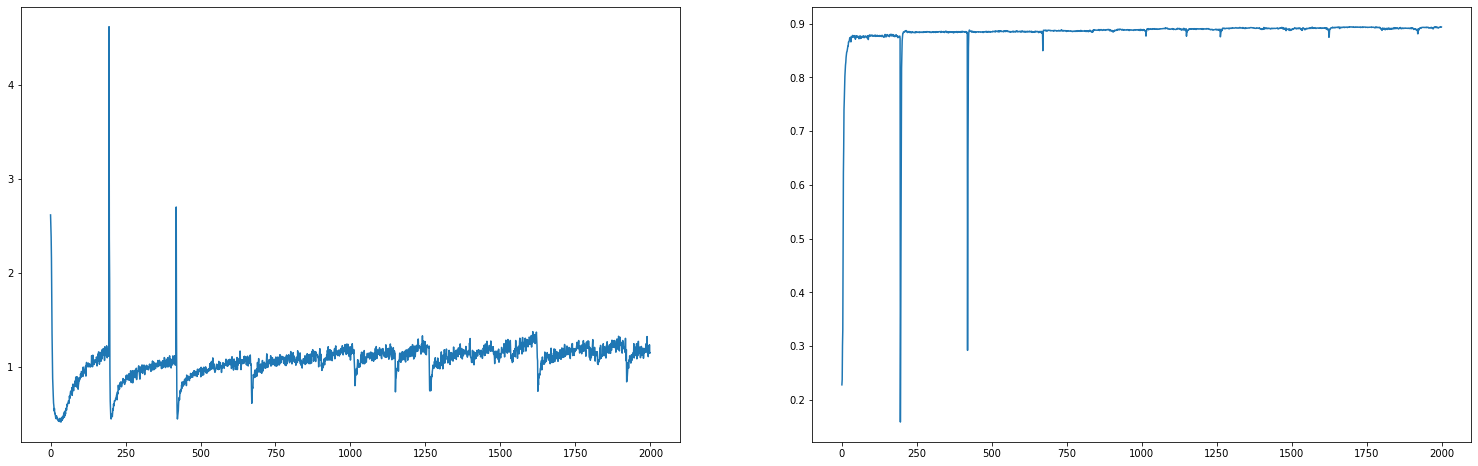

In [16]:
CUDA, LR, EPOCHS = torch.cuda.is_available(), 1e-3, 2000
#1e-2, 40
losses, accuracies = train_model(model,dl_tr,dl_val,cuda=CUDA,lr=LR,epochs=EPOCHS,show_plots=False, optimizer_factory=optim.AdamW)#,optimizer_parms=dict(momentum=.99)) 
l.extend(losses) 
a.extend(accuracies)
print('test',*eval_model(model,dl_test,CUDA,nn.NLLLoss()))
save_and_plot(model,l,a,'gru')

In [17]:
max(a), a.index(max(a))

(0.894606351852417, 1997)

In [18]:
from tabulate import tabulate

def show_pred(model, x,y=None):
    REVTAG = {v:k for k,v in _TAGS.items()}
    model.cpu()
    
    x = x.view(1,*x.shape)
    if y is not None:
        y = y.view(1,*y.shape)
    with torch.no_grad():
        pred = model(x)
    tkns = [tknzr.decode([int(x_)]) for x_ in x[0]]
    pred = pred.argmax(dim=-1)[0]
    #pred[y==-100] = -100
    l = (x!=0).nonzero(as_tuple=True)[0].shape[0] 
    return tkns[:l], [REVTAG[v.item()] for v in pred[:l]], ([REVTAG[v.item()] for v in y[0][:l]] if y is not None else None)
def mk_table(tkns,pred,actual=None):
    pass
#show_pred(model, torch.tensor(tknzr.encode("@MarioMonti, sei tu che dici le cose?").ids))

In [19]:
X,Y = next(iter(dl_test))
rows = []
for i in range(X.shape[0]//8):
    x,y = X[i],Y[i]
    with torch.no_grad():
        tkns, pred, actual = res = show_pred(model,x,y)
    rows.append(('Tokens',*tkns))
    rows.append(('Prediction',*pred))
    rows.append(('Actual',*actual))
    rows.append(['Correct',*map(lambda t: t[0]==t[1],zip(pred,actual))])
    rows.append([])
#print(y,model(x.view(1,*x.shape)).argmax(dim=-1))
tabulate(rows, tablefmt='html')

Tokens,,Io,mi,la,mento,della,gente,che,scri,ve,ancora,"""",fre,dd,y,mer,cu,ry,"""",ma,anche,quella,che,scri,ve,"""",,j,h,on,n,y,ca,sh,"""",non,s,cher,za,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Prediction,[BOS],PRON,PRON,NOUN,NOUN,ADP_A,NOUN,PRON,VERB,VERB,ADV,PUNCT,VERB,VERB,VERB,NOUN,NOUN,NOUN,PUNCT,CONJ,ADV,PRON,PRON,VERB,VERB,PUNCT,PROPN,PROPN,PROPN,PROPN,PROPN,PROPN,NOUN,NOUN,PUNCT,ADV,VERB,VERB,VERB,[EOS],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Actual,[BOS],PRON,PRON,VERB,VERB,ADP_A,NOUN,PRON,VERB,VERB,ADV,PUNCT,PROPN,PROPN,PROPN,PROPN,PROPN,PROPN,PUNCT,CONJ,ADV,PRON,PRON,VERB,VERB,PUNCT,PROPN,PROPN,PROPN,PROPN,PROPN,PROPN,PROPN,PROPN,PUNCT,ADV,VERB,VERB,VERB,[EOS],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Correct,True,True,True,False,False,True,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,True,True,True,True,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Tokens,,I,eri,a,Se,mpi,one,V,la,da,mi,ha,g,ri,dato,"""",S,TO,P,!!!,!,"""",e,io,come,una,co,gli,ona,ho,inizia,to,a,can,tare,"""",F,re,e,ze,"""",dei,B,lo,ck,B,.,K,po,p,cosa,mi,hai,fatto,.,,,,,,,,,,,,,,,,,,,,,
Prediction,[BOS],ADV,ADV,ADP,PROPN,PROPN,PROPN,PROPN,PROPN,PROPN,PRON,AUX,VERB,VERB,VERB,PUNCT,ADV,ADV,PROPN,PUNCT,PUNCT,PUNCT,CONJ,PRON,ADP,DET,NOUN,NOUN,NOUN,AUX,VERB,VERB,ADP,VERB,VERB,PUNCT,NOUN,NOUN,NOUN,NOUN,PUNCT,ADP_A,PROPN,PROPN,PROPN,PROPN,PUNCT,PROPN,PROPN,PROPN,PRON,PRON,AUX,VERB,PUNCT,[EOS],,,,,,,,,,,,,,,,,,,,
Actual,[BOS],ADV,ADV,ADP,PROPN,PROPN,PROPN,PROPN,PROPN,PROPN,PRON,AUX,VERB,VERB,VERB,PUNCT,NOUN,NOUN,NOUN,PUNCT,PUNCT,PUNCT,CONJ,PRON,ADP,DET,NOUN,NOUN,NOUN,AUX,VERB,VERB,ADP,VERB,VERB,PUNCT,PROPN,PROPN,PROPN,PROPN,PUNCT,ADP_A,PROPN,PROPN,PROPN,PROPN,PUNCT,PROPN,PROPN,PROPN,PRON,PRON,AUX,VERB,PUNCT,[EOS],,,,,,,,,,,,,,,,,,,,
Correct,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Tokens,,@,P,in,u,ccio,t,w,it,@,E,s,er,ci,to,C,ru,cia,n,la,Si,ci,lia,ha,sempre,capito,tutto,in,anti,ci,po,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
